In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout


In [2]:
data_folder = 'data/'
data_folder_mass = 'data/MassModels/'
data = np.loadtxt(data_folder_mass+'NGC2403.NFW.fix.REV.dat', skiprows=12) 
df = pd.DataFrame(data, columns=['Radius', 'vgas', 'vdisk', 'vbulge', 'vobs', 'err_vobs', 'Vu', 'Vt','Rxv', 'Vxy'])

In [3]:
N = len(df.values)
df.head()

,Radius,vgas,vdisk,vbulge,vobs,err_vobs,Vu,Vt,Rxv,Vxy
0,0.06252,-0.878,-1.02499,8.48001,1.98,6.926,12.9353,15.4081,0.0,0.0
1,0.12500,-1.771,4.32810,15.26710,15.78,7.691,18.2399,24.1117,0.0,0.0
2,0.18760,-2.740,8.67483,20.65930,22.30,4.584,22.2837,31.4820,0.0,0.0
3,0.25010,-3.448,12.47880,25.01450,32.16,4.542,25.6589,37.7881,0.0,0.0
4,0.31260,-3.847,16.36670,28.54780,39.67,4.433,28.6082,43.4336,0.0,0.0


In [4]:
df = df[['Radius', 'vobs','err_vobs', 'Vt']]
df.head()

,Radius,vobs,err_vobs,Vt
0,0.06252,1.98,6.926,15.4081
1,0.12500,15.78,7.691,24.1117
2,0.18760,22.30,4.584,31.4820
3,0.25010,32.16,4.542,37.7881
4,0.31260,39.67,4.433,43.4336


In [5]:
 df['Radius'].values

array([ 0.06252,  0.125  ,  0.1876 ,  0.2501 ,  0.3126 ,  0.3751 ,
        0.4377 ,  0.5002 ,  0.5627 ,  0.6252 ,  0.6878 ,  0.7503 ,
        0.8128 ,  0.8753 ,  0.9379 ,  1.     ,  1.063  ,  1.125  ,
        1.188  ,  1.25   ,  1.313  ,  1.376  ,  1.438  ,  1.501  ,
        1.563  ,  1.626  ,  1.688  ,  1.751  ,  1.813  ,  1.876  ,
        1.938  ,  2.001  ,  2.063  ,  2.126  ,  2.188  ,  2.251  ,
        2.313  ,  2.376  ,  2.438  ,  2.501  ,  2.563  ,  2.626  ,
        2.689  ,  2.751  ,  2.814  ,  2.876  ,  2.939  ,  3.001  ,
        3.064  ,  3.126  ,  3.189  ,  3.251  ,  3.314  ,  3.376  ,
        3.439  ,  3.501  ,  3.564  ,  3.626  ,  3.689  ,  3.751  ,
        3.814  ,  3.877  ,  3.939  ,  4.002  ,  4.064  ,  4.127  ,
        4.189  ,  4.252  ,  4.314  ,  4.377  ,  4.439  ,  4.502  ,
        4.564  ,  4.627  ,  4.689  ,  4.752  ,  4.814  ,  4.877  ,
        4.939  ,  5.002  ,  5.064  ,  5.127  ,  5.19   ,  5.252  ,
        5.315  ,  5.377  ,  5.44   ,  5.502  ,  5.565  ,  5.62

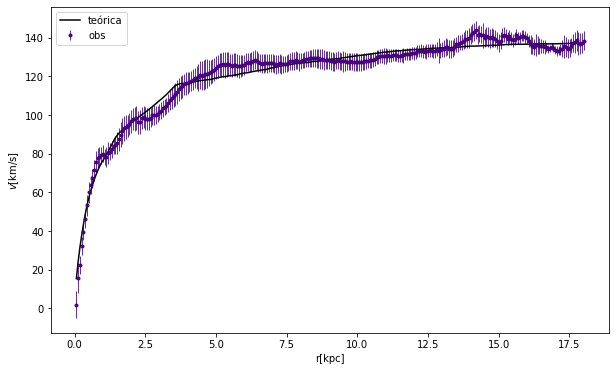

In [6]:
fig = plt.figure(figsize=(10, 6))
#plt.errorbar(mass_models[0].values, total['vrot'].values, yerr=total['err'].values, fmt='.', color='k', elinewidth=1, ecolor='green', label='total')
plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='indigo', elinewidth=1, ecolor='rebeccapurple', label='obs')
plt.plot(df['Radius'].values, df['Vt'].values, color='k', label='teórica')

plt.ylabel("$v$[km/s]")
plt.xlabel("r[kpc]")
plt.legend()

In [7]:
randomize = np.random.permutation(N)
data = df.values[randomize]

z = data[:,0]
y = data[:,1:3]

In [8]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [9]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(y_train), np.shape(z_test), np.shape(y_test)

((230, 1), (230, 2), (58, 1), (58, 2))

In [10]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [11]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))


Epoch 1/1000
58/58 [==============================] - 1s 4ms/step - loss: 6731.1855 - val_loss: 4760.5034
Epoch 2/1000
58/58 [==============================] - 0s 2ms/step - loss: 1719.7009 - val_loss: 1182.7664
Epoch 3/1000
58/58 [==============================] - 0s 2ms/step - loss: 809.1520 - val_loss: 676.7133
Epoch 4/1000
58/58 [==============================] - 0s 2ms/step - loss: 606.1714 - val_loss: 604.5779
Epoch 5/1000
58/58 [==============================] - 0s 2ms/step - loss: 421.4937 - val_loss: 414.1486
Epoch 6/1000
58/58 [==============================] - 0s 2ms/step - loss: 384.7149 - val_loss: 423.7191
Epoch 7/1000
58/58 [==============================] - 0s 2ms/step - loss: 307.0906 - val_loss: 300.7620
Epoch 8/1000
58/58 [==============================] - 0s 2ms/step - loss: 276.7457 - val_loss: 254.5789
Epoch 9/1000
58/58 [==============================] - 0s 2ms/step - loss: 270.6949 - val_loss: 240.9770
Epoch 10/1000
58/58 [==============================] - 0s 2m

58/58 [==============================] - 0s 2ms/step - loss: 79.6699 - val_loss: 132.0389
Epoch 80/1000
58/58 [==============================] - 0s 2ms/step - loss: 95.0698 - val_loss: 68.0885
Epoch 81/1000
58/58 [==============================] - 0s 2ms/step - loss: 75.7751 - val_loss: 89.5848
Epoch 82/1000
58/58 [==============================] - 0s 2ms/step - loss: 79.6087 - val_loss: 81.0437
Epoch 83/1000
58/58 [==============================] - 0s 2ms/step - loss: 69.0594 - val_loss: 64.0465
Epoch 84/1000
58/58 [==============================] - 0s 2ms/step - loss: 74.7270 - val_loss: 51.4895
Epoch 85/1000
58/58 [==============================] - 0s 2ms/step - loss: 75.2068 - val_loss: 67.6064
Epoch 86/1000
58/58 [==============================] - 0s 2ms/step - loss: 86.4148 - val_loss: 80.2505
Epoch 87/1000
58/58 [==============================] - 0s 2ms/step - loss: 90.8842 - val_loss: 62.9117
Epoch 88/1000
58/58 [==============================] - 0s 2ms/step - loss: 72.1889 - v

58/58 [==============================] - 0s 2ms/step - loss: 95.8303 - val_loss: 71.0493
Epoch 159/1000
58/58 [==============================] - 0s 2ms/step - loss: 72.0171 - val_loss: 92.2365
Epoch 160/1000
58/58 [==============================] - 0s 2ms/step - loss: 66.7995 - val_loss: 93.6957
Epoch 161/1000
58/58 [==============================] - 0s 2ms/step - loss: 74.9958 - val_loss: 50.2297
Epoch 162/1000
58/58 [==============================] - 0s 2ms/step - loss: 78.4449 - val_loss: 62.9085
Epoch 163/1000
58/58 [==============================] - 0s 2ms/step - loss: 77.3504 - val_loss: 74.9555
Epoch 164/1000
58/58 [==============================] - 0s 2ms/step - loss: 74.2443 - val_loss: 64.1754
Epoch 165/1000
58/58 [==============================] - 0s 2ms/step - loss: 72.7792 - val_loss: 66.3218
Epoch 166/1000
58/58 [==============================] - 0s 2ms/step - loss: 77.6504 - val_loss: 70.7126
Epoch 167/1000
58/58 [==============================] - 0s 2ms/step - loss: 86.

Epoch 237/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.8005 - val_loss: 60.5851
Epoch 238/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.3431 - val_loss: 65.8041
Epoch 239/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.1134 - val_loss: 59.2743
Epoch 240/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.8428 - val_loss: 74.5973
Epoch 241/1000
58/58 [==============================] - 0s 2ms/step - loss: 68.5118 - val_loss: 53.7463
Epoch 242/1000
58/58 [==============================] - 0s 2ms/step - loss: 75.6654 - val_loss: 58.5461
Epoch 243/1000
58/58 [==============================] - 0s 2ms/step - loss: 63.2137 - val_loss: 60.2256
Epoch 244/1000
58/58 [==============================] - 0s 2ms/step - loss: 65.9357 - val_loss: 47.0517
Epoch 245/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.4372 - val_loss: 73.6334
Epoch 246/1000
58/58 [==============================] - 0s 2ms/s

Epoch 316/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.1801 - val_loss: 69.8932
Epoch 317/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.2738 - val_loss: 95.6127
Epoch 318/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.9041 - val_loss: 75.1403
Epoch 319/1000
58/58 [==============================] - 0s 2ms/step - loss: 66.4452 - val_loss: 42.1083
Epoch 320/1000
58/58 [==============================] - 0s 2ms/step - loss: 69.2053 - val_loss: 58.8786
Epoch 321/1000
58/58 [==============================] - 0s 2ms/step - loss: 71.3173 - val_loss: 45.3500
Epoch 322/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.0353 - val_loss: 58.5089
Epoch 323/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.9507 - val_loss: 71.6805
Epoch 324/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.4624 - val_loss: 68.0187
Epoch 325/1000
58/58 [==============================] - 0s 2ms/s

Epoch 395/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.5925 - val_loss: 63.8686
Epoch 396/1000
58/58 [==============================] - 0s 2ms/step - loss: 66.8403 - val_loss: 76.7426
Epoch 397/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.3086 - val_loss: 46.1544
Epoch 398/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.3592 - val_loss: 80.4298
Epoch 399/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.2292 - val_loss: 55.0729
Epoch 400/1000
58/58 [==============================] - 0s 2ms/step - loss: 65.2389 - val_loss: 50.5764
Epoch 401/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.2167 - val_loss: 51.0304
Epoch 402/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.5751 - val_loss: 46.2240
Epoch 403/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.6210 - val_loss: 62.2784
Epoch 404/1000
58/58 [==============================] - 0s 2ms/s

Epoch 474/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.0015 - val_loss: 70.5976
Epoch 475/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.3763 - val_loss: 73.2602
Epoch 476/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.9339 - val_loss: 56.9328
Epoch 477/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.4337 - val_loss: 54.8452
Epoch 478/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.8904 - val_loss: 45.4210
Epoch 479/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.1427 - val_loss: 54.0175
Epoch 480/1000
58/58 [==============================] - 0s 2ms/step - loss: 46.4400 - val_loss: 72.9951
Epoch 481/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.1550 - val_loss: 61.7321
Epoch 482/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.8202 - val_loss: 67.4808
Epoch 483/1000
58/58 [==============================] - 0s 2ms/s

Epoch 553/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.1772 - val_loss: 58.0097
Epoch 554/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.0339 - val_loss: 48.9650
Epoch 555/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.3519 - val_loss: 52.1065
Epoch 556/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.0194 - val_loss: 77.4859
Epoch 557/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.2940 - val_loss: 44.4053
Epoch 558/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.4449 - val_loss: 55.1289
Epoch 559/1000
58/58 [==============================] - 0s 2ms/step - loss: 45.4926 - val_loss: 41.1188
Epoch 560/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.6406 - val_loss: 50.4188
Epoch 561/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.7226 - val_loss: 54.4003
Epoch 562/1000
58/58 [==============================] - 0s 2ms/s

Epoch 632/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.8483 - val_loss: 43.7051
Epoch 633/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.0049 - val_loss: 74.0056
Epoch 634/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.3265 - val_loss: 54.7954
Epoch 635/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.0590 - val_loss: 53.8073
Epoch 636/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.8227 - val_loss: 56.9202
Epoch 637/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.1292 - val_loss: 48.6919
Epoch 638/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.4876 - val_loss: 38.6505
Epoch 639/1000
58/58 [==============================] - 0s 2ms/step - loss: 49.7088 - val_loss: 75.2448
Epoch 640/1000
58/58 [==============================] - 0s 2ms/step - loss: 46.4907 - val_loss: 43.6807
Epoch 641/1000
58/58 [==============================] - 0s 2ms/s

Epoch 711/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.3655 - val_loss: 50.2711
Epoch 712/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.7077 - val_loss: 58.1694
Epoch 713/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.2530 - val_loss: 70.4844
Epoch 714/1000
58/58 [==============================] - 0s 2ms/step - loss: 45.3395 - val_loss: 46.1812
Epoch 715/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.3018 - val_loss: 62.7700
Epoch 716/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.5269 - val_loss: 44.8683
Epoch 717/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.3702 - val_loss: 34.5218
Epoch 718/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.0453 - val_loss: 43.6443
Epoch 719/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.5999 - val_loss: 50.8939
Epoch 720/1000
58/58 [==============================] - 0s 2ms/s

Epoch 790/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.3570 - val_loss: 37.2759
Epoch 791/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.2908 - val_loss: 58.7635
Epoch 792/1000
58/58 [==============================] - 0s 2ms/step - loss: 45.5021 - val_loss: 43.9266
Epoch 793/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.6197 - val_loss: 39.2879
Epoch 794/1000
58/58 [==============================] - 0s 2ms/step - loss: 49.4753 - val_loss: 54.3204
Epoch 795/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.3233 - val_loss: 53.4836
Epoch 796/1000
58/58 [==============================] - 0s 2ms/step - loss: 50.8252 - val_loss: 66.3555
Epoch 797/1000
58/58 [==============================] - 0s 2ms/step - loss: 46.8222 - val_loss: 45.1220
Epoch 798/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.7570 - val_loss: 38.3175
Epoch 799/1000
58/58 [==============================] - 0s 2ms/s

Epoch 869/1000
58/58 [==============================] - 0s 2ms/step - loss: 44.3150 - val_loss: 58.0561
Epoch 870/1000
58/58 [==============================] - 0s 2ms/step - loss: 44.2778 - val_loss: 58.4138
Epoch 871/1000
58/58 [==============================] - 0s 2ms/step - loss: 44.4818 - val_loss: 58.6564
Epoch 872/1000
58/58 [==============================] - 0s 2ms/step - loss: 42.2669 - val_loss: 31.3575
Epoch 873/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.1058 - val_loss: 46.9750
Epoch 874/1000
58/58 [==============================] - 0s 2ms/step - loss: 45.4755 - val_loss: 48.4004
Epoch 875/1000
58/58 [==============================] - 0s 2ms/step - loss: 42.5965 - val_loss: 43.9725
Epoch 876/1000
58/58 [==============================] - 0s 2ms/step - loss: 38.6197 - val_loss: 44.3783
Epoch 877/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.3299 - val_loss: 68.5314
Epoch 878/1000
58/58 [==============================] - 0s 2ms/s

Epoch 948/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.2190 - val_loss: 41.2303
Epoch 949/1000
58/58 [==============================] - 0s 2ms/step - loss: 45.1348 - val_loss: 64.5720
Epoch 950/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.5370 - val_loss: 52.4794
Epoch 951/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.6059 - val_loss: 39.5044
Epoch 952/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.5498 - val_loss: 46.6064
Epoch 953/1000
58/58 [==============================] - 0s 2ms/step - loss: 50.3689 - val_loss: 38.9424
Epoch 954/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.0002 - val_loss: 46.2885
Epoch 955/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.8214 - val_loss: 57.4008
Epoch 956/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.4967 - val_loss: 42.0575
Epoch 957/1000
58/58 [==============================] - 0s 2ms/s

In [12]:
model_train.history['val_loss'][-1]

31.41510772705078

In [13]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(min(df['Radius'].values)-0.1, max(df['Radius'].values)+0.1, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



32/32 [==============================] - 0s 1ms/step


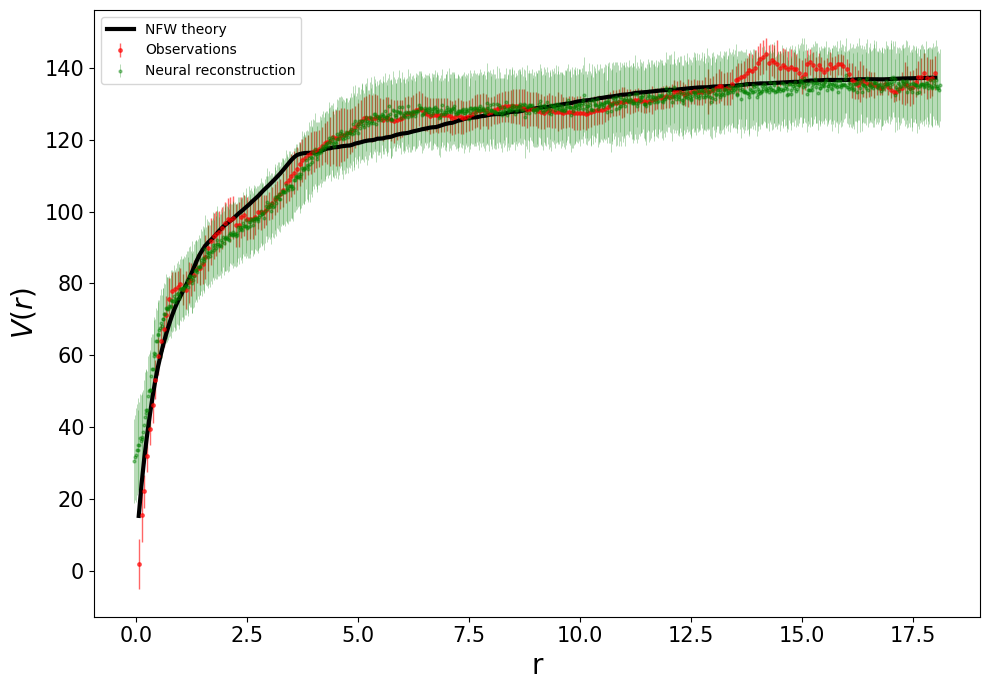

In [14]:
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
overlapping = 0.6
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)



plt.plot(df['Radius'].values, df['Vt'].values, color='k', linewidth=3, label='NFW theory',alpha=1)

plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='red', elinewidth=1, ecolor='red', markersize=5, label='Observations', alpha=overlapping)

plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='green', capthick=2, elinewidth=0.5, alpha=overlapping-0.2, c='green',
             label='Neural reconstruction')


plt.ylabel("$V(r)$", fontsize=20)
plt.xlabel("r", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig("neural_reconstruction_RC.png", dpi=100)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

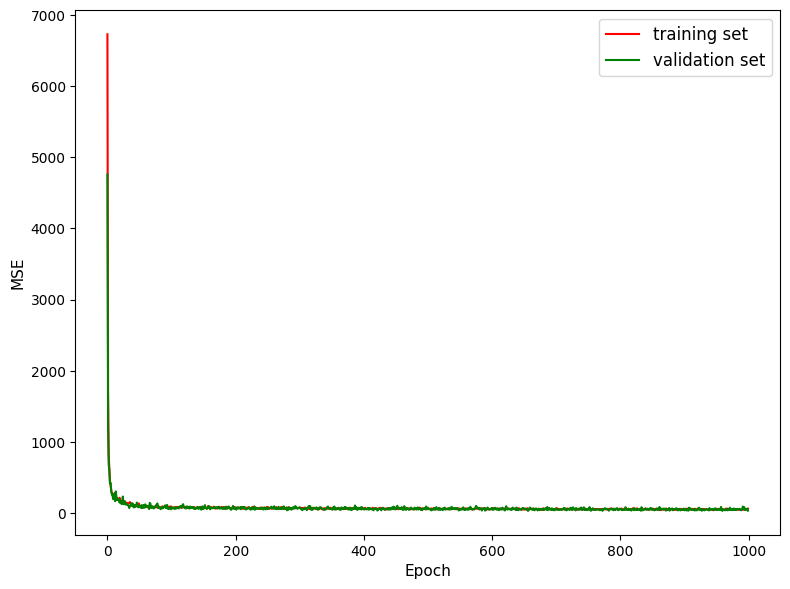

In [15]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
# plt.ylim(0, 200)